<a href="https://colab.research.google.com/github/Cpt-Shaan/deep-stuff/blob/main/ANNs/MNIST_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataset = MNIST(root = 'data/', download = True)
print(len(dataset))

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.37MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.21MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000


In [ ]:
type(dataset)

torchvision.datasets.mnist.MNIST

In [ ]:
print(dataset[400])

(<PIL.Image.Image image mode=L size=28x28 at 0x7AA637D79D20>, 2)


Label: 2


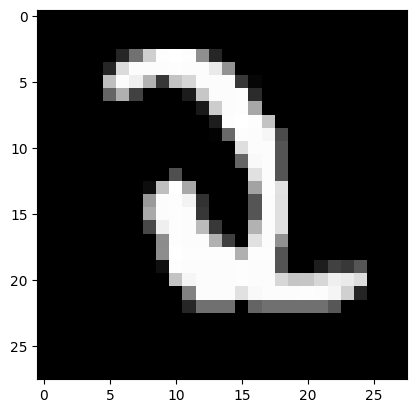

In [ ]:
image, label = dataset[400]
plt.imshow(image, cmap = 'gray')
print('Label:', label)

In [ ]:
train_data = MNIST(root = 'data/', train = True, transform = transforms.ToTensor())
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [ ]:
test_data = MNIST(root = 'data/', train = False, transform = transforms.ToTensor())
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: ToTensor()


In [ ]:
batch_size = 2048
train_loader = DataLoader(train_data, batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size)

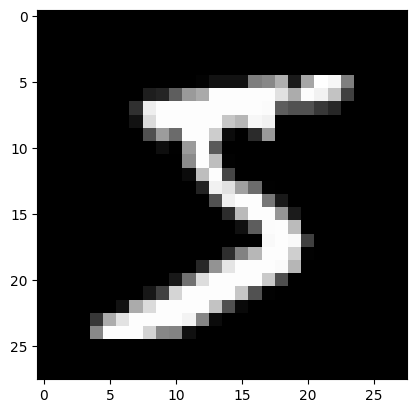

In [ ]:
plt.imshow(train_data[0][0].reshape(28,28), cmap = 'gray')

In [ ]:
input_size = 784
classes = 10

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return(torch.tensor(torch.sum(preds == labels).item()/ len(preds)))

class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, classes)

    def forward(self, x):
        x = x.reshape(-1, 784)
        z = self.linear(x)

        return(z)

    def training_step(self, batch):
        images, labels = batch
        out = self(images) ## Generate predictions
        loss = F.cross_entropy(out, labels) ## Calculate the loss
        return(loss)

    def test_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return({'test_loss':loss, 'test_acc': acc})

    def test_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'test_loss': epoch_loss.item(), 'test_acc' : epoch_acc.item()})

    def epoch_end(self, epoch,result):
        print("Epoch [{}], test_loss: {:.4f}, test_acc: {:.4f}".format(epoch, result['test_loss'], result['test_acc']))

model = MnistModel()
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[ 0.0309, -0.0115, -0.0276,  ...,  0.0113,  0.0052, -0.0083],
         [-0.0253, -0.0316,  0.0057,  ..., -0.0079, -0.0164,  0.0027],
         [-0.0294,  0.0257,  0.0272,  ...,  0.0158,  0.0182, -0.0099],
         ...,
         [-0.0171, -0.0237, -0.0117,  ...,  0.0353,  0.0170,  0.0296],
         [-0.0093, -0.0160, -0.0301,  ...,  0.0281, -0.0040, -0.0342],
         [ 0.0205, -0.0218,  0.0253,  ..., -0.0138,  0.0050,  0.0222]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0331,  0.0208, -0.0057,  0.0263,  0.0352,  0.0004, -0.0006,  0.0065,
          0.0225, -0.0333], requires_grad=True)]

In [ ]:
def evaluate(model, test_loader):
    outputs = [model.test_step(batch) for batch in test_loader]
    return(model.test_epoch_end(outputs))

def fit(epochs, lr, model, train_loader, test_loader, opt_func = torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        ## Training Phas
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        ## Testing phase
        result = evaluate(model, test_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return(history)

In [ ]:
history = fit(100, 0.006, model, train_loader, test_loader)

Epoch [0], test_loss: 2.1479, test_acc: 0.3874
Epoch [1], test_loss: 1.9806, test_acc: 0.5999
Epoch [2], test_loss: 1.8374, test_acc: 0.6867
Epoch [3], test_loss: 1.7129, test_acc: 0.7314
Epoch [4], test_loss: 1.6043, test_acc: 0.7572
Epoch [5], test_loss: 1.5094, test_acc: 0.7720
Epoch [6], test_loss: 1.4262, test_acc: 0.7838
Epoch [7], test_loss: 1.3532, test_acc: 0.7948
Epoch [8], test_loss: 1.2889, test_acc: 0.8014
Epoch [9], test_loss: 1.2319, test_acc: 0.8081
Epoch [10], test_loss: 1.1812, test_acc: 0.8136
Epoch [11], test_loss: 1.1360, test_acc: 0.8170
Epoch [12], test_loss: 1.0953, test_acc: 0.8203
Epoch [13], test_loss: 1.0586, test_acc: 0.8233
Epoch [14], test_loss: 1.0254, test_acc: 0.8259
Epoch [15], test_loss: 0.9951, test_acc: 0.8279
Epoch [16], test_loss: 0.9676, test_acc: 0.8310
Epoch [17], test_loss: 0.9423, test_acc: 0.8329
Epoch [18], test_loss: 0.9191, test_acc: 0.8344
Epoch [19], test_loss: 0.8976, test_acc: 0.8371
Epoch [20], test_loss: 0.8778, test_acc: 0.8391
Ep

In [ ]:
history2 = fit(50, 0.008, model, train_loader, test_loader)

Epoch [0], test_loss: 0.4793, test_acc: 0.8824
Epoch [1], test_loss: 0.4774, test_acc: 0.8824
Epoch [2], test_loss: 0.4756, test_acc: 0.8832
Epoch [3], test_loss: 0.4738, test_acc: 0.8836
Epoch [4], test_loss: 0.4721, test_acc: 0.8840
Epoch [5], test_loss: 0.4704, test_acc: 0.8846
Epoch [6], test_loss: 0.4687, test_acc: 0.8847
Epoch [7], test_loss: 0.4670, test_acc: 0.8849
Epoch [8], test_loss: 0.4654, test_acc: 0.8850
Epoch [9], test_loss: 0.4639, test_acc: 0.8849
Epoch [10], test_loss: 0.4623, test_acc: 0.8853
Epoch [11], test_loss: 0.4608, test_acc: 0.8856
Epoch [12], test_loss: 0.4593, test_acc: 0.8858
Epoch [13], test_loss: 0.4578, test_acc: 0.8861
Epoch [14], test_loss: 0.4564, test_acc: 0.8862
Epoch [15], test_loss: 0.4550, test_acc: 0.8865
Epoch [16], test_loss: 0.4536, test_acc: 0.8868
Epoch [17], test_loss: 0.4522, test_acc: 0.8869
Epoch [18], test_loss: 0.4509, test_acc: 0.8870
Epoch [19], test_loss: 0.4496, test_acc: 0.8870
Epoch [20], test_loss: 0.4483, test_acc: 0.8870
Ep

In [ ]:
history3 = fit(50, 0.002, model, train_loader, test_loader)

Epoch [0], test_loss: 0.4182, test_acc: 0.8929
Epoch [1], test_loss: 0.4180, test_acc: 0.8930
Epoch [2], test_loss: 0.4178, test_acc: 0.8933
Epoch [3], test_loss: 0.4176, test_acc: 0.8934
Epoch [4], test_loss: 0.4173, test_acc: 0.8934
Epoch [5], test_loss: 0.4171, test_acc: 0.8934
Epoch [6], test_loss: 0.4169, test_acc: 0.8934
Epoch [7], test_loss: 0.4167, test_acc: 0.8934
Epoch [8], test_loss: 0.4165, test_acc: 0.8934
Epoch [9], test_loss: 0.4163, test_acc: 0.8935
Epoch [10], test_loss: 0.4161, test_acc: 0.8935
Epoch [11], test_loss: 0.4159, test_acc: 0.8936
Epoch [12], test_loss: 0.4157, test_acc: 0.8936
Epoch [13], test_loss: 0.4155, test_acc: 0.8935
Epoch [14], test_loss: 0.4153, test_acc: 0.8935
Epoch [15], test_loss: 0.4151, test_acc: 0.8937
Epoch [16], test_loss: 0.4149, test_acc: 0.8937
Epoch [17], test_loss: 0.4147, test_acc: 0.8938
Epoch [18], test_loss: 0.4145, test_acc: 0.8939
Epoch [19], test_loss: 0.4144, test_acc: 0.8939
Epoch [20], test_loss: 0.4142, test_acc: 0.8939
Ep

Text(0.5, 1.0, 'Accuracy Vs. No. of epochs')

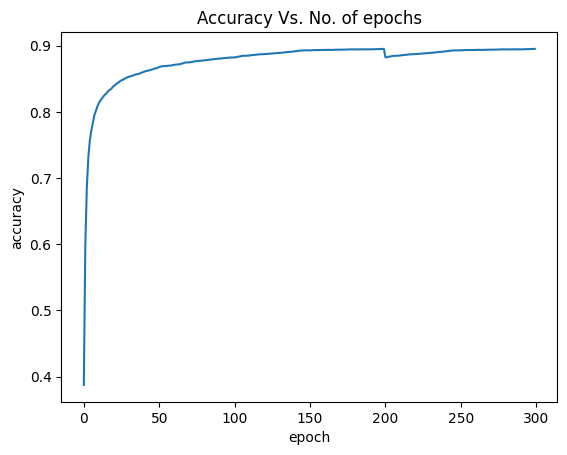

In [ ]:
history = history + history2 + history3
accuracies = [result['test_acc'] for result in history]
plt.plot(accuracies)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Vs. No. of epochs')